In [1]:
import nltk
from nltk.corpus import names
from pylab import *
import random as pyrandom

# A Simple Classifier

In [2]:
def gender_features(w):
    return dict(last_letter=w[-1],
                first_letter=w[0],
                length=len(w))
gender_features("Petra")

{'first_letter': 'P', 'last_letter': 'a', 'length': 5}

In [4]:
male = [(name,'male') for name in names.words('male.txt')]
female = [(name,'female') for name in names.words('female.txt')]
nlist = male+female
pyrandom.shuffle(nlist)
featuresets = [(gender_features(n),g) for n,g in nlist]
training_set = featuresets[500:]
test_set = featuresets[:500]

In [5]:
classifier = nltk.NaiveBayesClassifier.train(training_set)

# Accuracy and Error Rate

In [14]:
nltk.classify.accuracy(classifier,test_set)

0.788

In [15]:
truth = [s[1] for s in test_set]
predicted = classifier.batch_classify([s[0] for s in test_set])

In [17]:
nltk.metrics.accuracy(truth,predicted)

0.788

In [20]:
sum(array(truth)==array(predicted))*1.0/len(truth)

0.78800000000000003

In [28]:
sum(array(truth)!=array(predicted))*1.0/len(truth)

0.21199999999999999

# Confusion Matrix

In [34]:
cm = nltk.ConfusionMatrix(truth,predicted)

In [36]:
print cm.pp()

       |   f     |
       |   e     |
       |   m   m |
       |   a   a |
       |   l   l |
       |   e   e |
-------+---------+
female |<261> 48 |
  male |  58<133>|
-------+---------+
(row = reference; col = test)



Usually, we use the confusion matrix in multi-class problems to see which classes are particularly frequently confused.

However, in a binary classification problem, it also gives us the four categories of error. If we think of the above problem as a "female detector", then...

- true positives = 261
- true negatives = 133
- false positives = 48
- false negatives = 58

# Precision and Recall

Precision and recall is a way of thinking about errors in terms of "retrieved items".

Think of the classification problem as the problem of "retrieving all the records that are female".
Then we define:

- precision = fraction of retrieved documents that were relevant = TP / (TP + FP)
- recall = fraction of all positives that were actually retrieved = TP / (TP + FN)


In [25]:
pdocs = set(find(array(predicted)=="female"))
tdocs = set(find(array(truth)=="female"))

In [26]:
nltk.metrics.precision(tdocs,pdocs)

0.8181818181818182

In [27]:
nltk.metrics.recall(tdocs,pdocs)

0.8446601941747572

In [30]:
nltk.metrics.f_measure(tdocs,pdocs)

0.8312101910828026

In [32]:
nltk.metrics.f_measure(tdocs,pdocs,alpha=0.9)

0.8207547169811322

# ROC Curve

In [47]:
features = [t[0].items() for t in training_set]
features = list(sorted(set([x for l in features for x in l])))
len(features)

66

In [49]:
xs = zeros((len(training_set),len(features)))
ys = zeros(len(training_set))
for i,(f,c) in enumerate(training_set):
    for p in f.items():
        xs[i,features.index(p)] = 1.0
        ys[i] = (c=="female")

In [50]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(xs,ys)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', tol=0.0001)

In [58]:
test_xs = zeros((len(test_set),len(features)))
test_ys = zeros(len(test_set))
for i,(f,c) in enumerate(test_set):
    for p in f.items():
        test_xs[i,features.index(p)] = 1.0
        test_ys[i] = (c=="female")

In [62]:
pred = lr.predict(test_xs)
sum(pred!=test_ys)*1.0/len(test_ys)

0.218

In [69]:
def tpfp(truth,pred):
    tp = sum((truth>.5)*(pred>.5))*1.0/len(truth)
    fp = sum((truth<.5)*(pred>.5))*1.0/len(truth)
    return tp,fp

In [70]:
truth = test_ys
prob = lr.predict_proba(test_xs)[:,1]

In [71]:
roc = [tpfp(truth,prob>threshold) for threshold in linspace(0,1.0,100)]
    

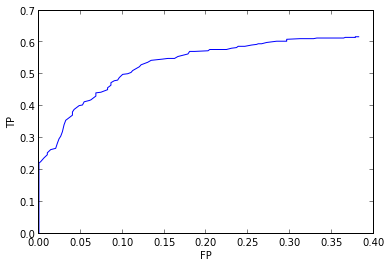

In [74]:
tps,fps = zip(*roc)
plot(fps,tps)
xlabel("FP")
ylabel("TP")

# Cross-Validation

In [80]:
featuresets = [(gender_features(n),g) for n,g in nlist]
accuracies = []
for start in range(0,len(featuresets),500):
    training_set = featuresets[:start]+featuresets[start+500:]
    test_set = featuresets[start:start+500]
    classifier = nltk.NaiveBayesClassifier.train(training_set)
    a = nltk.classify.accuracy(classifier,test_set)
    accuracies.append(a)
    print start,a
print mean(accuracies)

0 0.788
500 0.778
1000 0.782
1500 0.778
2000 0.79
2500 0.786
3000 0.77
3500 0.78
4000 0.764
4500 0.802
5000 0.778
5500 0.768
6000 0.722
6500 0.804
7000 0.744
7500 0.783783783784
0.776111486486


In [76]:
len(featuresets)

7944

# Resampling Estimates

In [84]:
featuresets = [(gender_features(n),g) for n,g in nlist]
accuracies = []
gold_set = featuresets[500:]
test_set = featuresets[:500]
for trial in range(20):
    training_set = [pyrandom.choice(gold_set) for i in range(len(gold_set))]
    classifier = nltk.NaiveBayesClassifier.train(training_set)
    a = nltk.classify.accuracy(classifier,test_set)
    accuracies.append(a)
print mean(accuracies)

0.7841


In [85]:
1

1